# FrugalAI challenge - Chainsaws - preparing a model for Pico

### Naive approach, `v11b`


```
Copyright (c) 2025  @kelu124, Arm Limited, and Contributors. All rights reserved.

SPDX-License-Identifier: Apache-2.0
```

* Based on initial work by : [Sandeep Mistry](https://twitter.com/sandeepmistry), [Henri Woodcock](https://twitter.com/henriwoodcock) from the [Arm Software Developers team](https://twitter.com/armsoftwaredev)


Documentation :
* [The authors initial work](https://colab.research.google.com/github/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/ml_audio_classifier_example_for_pico.ipynb)
* This [notebook](https://colab.research.google.com/drive/16OmmqPclU-e1uhNwE0tGWASBocvlu5DA?usp=sharing)
* Other resources:
  * https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data


## Install dependencies

### Python Libraries

Let's start by installing the Python library dependencies:

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

In [ ]:
!pip install tf_keras

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [ ]:
REDO = True

In [ ]:
#!pip install -r /content/drive/MyDrive/frugal/requirements.txt
!pip install tensorflow-io tensorflow tensorflow-model-optimization librosa matplotlib pandas datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# # Pico related library
!pip install git+https://github.com/ARM-software/CMSIS_5.git@5.8.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/PythonWrapper
#!pip freeze > /content/drive/MyDrive/frugal/requirements.txt

  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.8.0) to /tmp/pip-install-qguba5bt/cmsisdsp_f20e6008d55f4856b29c241dbc5ad647
  Running command git clone --filter=blob:none --quiet https://github.com/ARM-software/CMSIS_5.git /tmp/pip-install-qguba5bt/cmsisdsp_f20e6008d55f4856b29c241dbc5ad647
  Running command git checkout -q 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Resolved https://github.com/ARM-software/CMSIS_5.git to commit 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Preparing metadata (setup.py) ... done
  Created wheel for CMSISDSP: filename=CMSISDSP-1.0.0-cp311-cp311-linux_x86_64.whl size=1354776 sha256=68b77737327c6ae57b721007ef00fcdf9fd4dfe5f8474e2b2eb4b2105fc0a9c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-yi915hja/wheels/b2/84/47/073dc9eab0d876dd32dff0c0bd5b60722ce49118d120a6bcb5
Successfully built CMSISDSP


In [ ]:
!python --version
!pip --version


Python 3.11.11
pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)


In [ ]:
import tensorflow as tf
# Connect to google drive

print(tf.version.GIT_VERSION, tf.version.VERSION)
print(tf.__version__)

import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import soundfile as sf
import json
from os import path
from datasets import load_dataset

v2.17.0-rc1-2-gad6d8cc177d 2.17.0
2.17.0


## Baseline model

Dataset: HuggingFace: "rfcx/frugalai"

### Prepare dataset

#### Download and extract

In [ ]:
# download the dataset
# Have your HuggingFace HF_TOKEN ready and made available!
dasaset = load_dataset(
  "rfcx/frugalai",
  name="default",
  num_proc=10,
  cache_dir="cache/"
)

README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Setting num_proc from 10 to 6 for the train split as it only contains 6 shards.


Generating train split:   0%|          | 0/35277 [00:00<?, ? examples/s]

In [ ]:
# Choose the setting of spectrogram between
# 1 for create_spectrogram_for_map
# 2 for create_arm_spectrogram_for_map
# 3 Mel spectrogram

spectrogram_setting = "create_arm_spectrogram_for_map"

print("Choice:",spectrogram_setting)

## Creating sound files

#### Load wave file data

We can then define a new function named `load_wav` to load audio samples from a wave file using TensorFlow's [`tf.io.read_file(...)`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) and[`tf.audio.decode_wav(...)`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) API's. The [`tfio.audio.resample(...)`](https://www.tensorflow.org/io/api_docs/python/tfio/audio/resample) API will be used to resample the audio samples at the specified sampling rate.

[librosa](https://librosa.org/)'s [`load(...)`](https://librosa.org/doc/main/generated/librosa.load.html) API will be used as a fallback if TensorFlow is unable to decode the wave file.


Now let's load the first wave file, from the pandas `DataFrame`, and plot it overtime using `matplotlib`. The [`IPython.display.Audio(...)`](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.Audio) API can be used to playback the audio samples inside the notebook.




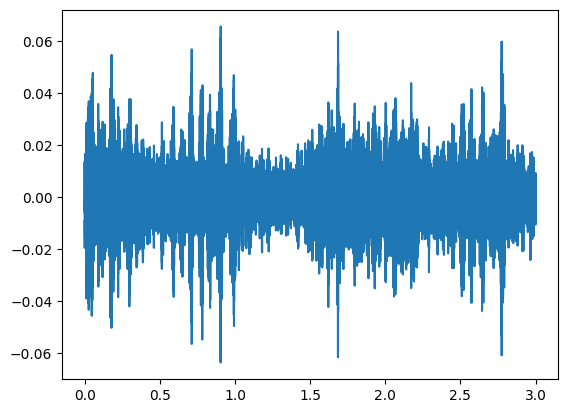

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

sample_rate = 12000
channels = 1

test_wav_data = dasaset['train'][0]['audio']['array']

plt.plot([x/12000 for x in range(len(test_wav_data))],test_wav_data)
plt.show()

display.Audio(test_wav_data, rate=sample_rate)

We can then use the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) TensorFlow API to create a pipeline that loads all wave file data from the dataset.

In [ ]:
import random

# Define a generator function for the dataset
def dataset_generator(dataset):
    for example in dataset:
        audio_array = example['audio']['array']
        label = example['label']
        # Randomly sample 1-5 integers
        fold = random.choice([0, 1, 2, 3, 4])
        yield audio_array, label, fold

# Define a filter function to remove samples with audio length != 36000
def filter_by_length(audio, label, path):
    return tf.equal(tf.shape(audio)[0], 36000)

# Convert the dataset to a TensorFlow dataset
split_wav_ds = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dasaset['train']),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),  # Audio array
        tf.TensorSpec(shape=(), dtype=tf.int64),         # Label
        tf.TensorSpec(shape=(), dtype=tf.int64)         # Path
    )
)

split_wav_ds = split_wav_ds.filter(filter_by_length)


# Convert the dataset to a TensorFlow dataset
test_ds = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dasaset['test']),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),  # Audio array
        tf.TensorSpec(shape=(), dtype=tf.int64),         # Label
        tf.TensorSpec(shape=(), dtype=tf.int64)         # Path
    )
)

test_ds = test_ds.filter(filter_by_length)

#### Create Spectrograms


Then we can map each split wave item to a spectrogram:

In [ ]:
import cmsisdsp
from numpy import pi as PI

window_size = 256
step_size = 128*8

hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
  hanning_window_f32[i] = 0.5 * (1 - cmsisdsp.arm_cos_f32(2 * PI * i / window_size ))

hanning_window_q15 = cmsisdsp.arm_float_to_q15(hanning_window_f32)

rfftq15 = cmsisdsp.arm_rfft_instance_q15()
status = cmsisdsp.arm_rfft_init_q15(rfftq15, window_size, 0, 1)

def get_arm_spectrogram(waveform):

  num_frames = int(1 + (len(waveform) - window_size) // step_size)
  fft_size = int(window_size // 2 + 1)
  # normalisation du son
  #waveform = waveform/np.max(np.abs(waveform))-np.mean(waveform)
  waveform = 8*256.0 * (waveform/np.max(np.abs(waveform))-np.mean(waveform))
  # Convert the audio to q15
  waveform_q15 = cmsisdsp.arm_float_to_q15(waveform)
  #print(waveform_q15)
  # Create empty spectrogram array
  spectrogram_q15 = np.empty((num_frames, fft_size), dtype = np.int16)

  start_index = 0

  for index in range(num_frames):
    # Take the window from the waveform.
    window = waveform_q15[start_index:start_index + window_size]

    # Apply the Hanning Window.
    window = cmsisdsp.arm_mult_q15(window, hanning_window_q15)

    # Calculate the FFT, shift by 7 according to docs
    window = cmsisdsp.arm_rfft_q15(rfftq15, window)

    # Take the absolute value of the FFT and add to the Spectrogram.
    spectrogram_q15[index] = cmsisdsp.arm_cmplx_mag_q15(window)[:fft_size]

    # Increase the start index of the window by the overlap amount.
    start_index += step_size

  # Convert to numpy output ready for keras
  OUT = cmsisdsp.arm_q15_to_float(spectrogram_q15).reshape(num_frames,fft_size) * 512
  if 1:
    AVG = np.average(OUT[0,110:])
    MAX = np.max(OUT)
    OUT = OUT/ MAX
  return tf.reshape(OUT, shape=(35, 129))

In [ ]:
def create_arm_spectrogram_for_map(samples, label, fold):
    spectrogram = tf.py_function(get_arm_spectrogram, [samples], tf.float32)
    return spectrogram, label, fold



spectrograms_ds = split_wav_ds.map(create_arm_spectrogram_for_map)
spectrograms_ds.element_spec
test_ds = test_ds.map(create_arm_spectrogram_for_map)
test_ds.element_spec

print("Passed through ",spectrogram_setting)

Passed through  create_arm_spectrogram_for_map


Let's plot the first 3 spectrograms in the dataset:

In [ ]:
import numpy as np

def plot_spectrogram(spectrogram, vmax=None):
  transposed_spectrogram = tf.transpose(spectrogram)

  fig = plt.figure(figsize=(8,6))
  height = transposed_spectrogram.shape[0]
  X = np.arange(transposed_spectrogram.shape[1])
  Y = np.arange(height * int(sample_rate / 256), step=int(sample_rate / 256))

  im = plt.pcolormesh(X, Y, tf.transpose(spectrogram), vmax=vmax)

  fig.colorbar(im)
  plt.show()

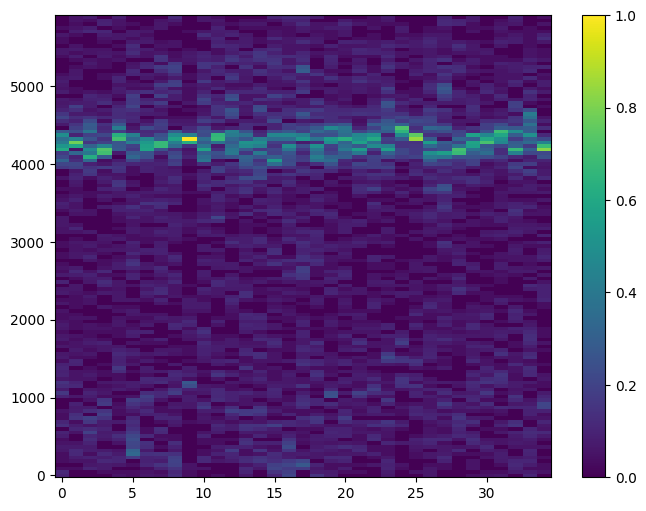

In [ ]:
# 1min
for s, _, _ in spectrograms_ds.take(1):
    plot_spectrogram(s)

### Split Dataset

Before we start training the ML classifier model, we must split the dataset up in three parts: training, validation, and test.

We will use the same technique in TensorFlow's [Transfer learning with YAMNet for environmental sound classification](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data) guide, and use the `fold` column of the ESC-50 dataset to determine the split.

Before splitting the dataset, let's set a random seed for reproducibility:

In [ ]:
import numpy as np
import tensorflow as tf

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Entries with a `fold` value of less than 4 will used for training, the ones with a `value` will be used for validation, and finally the remaining items with be used for testing.

The `fold` column will be removed as it is no longer needed, and the dimensions of the spectrogram shape will be expanded from `(124, 129)` to `(124, 129, 1)`. The training items will also be shuffled.

In [ ]:
#15s
cached_ds = spectrograms_ds.cache()
test_ds = test_ds.cache()

In [ ]:
BATCHSIZE=32

In [ ]:
train_ds = cached_ds.filter(lambda spectrogram, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda spectrogram, label, fold: fold == 4)

# remove the folds column as it's no longer needed
# remove_fold_column = lambda spectrogram, label, fold: (tf.expand_dims(spectrogram, axis=-1), label)

def remove_fold_column(spectrogram, label, fold):
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram.set_shape([35, 129, 1])
    print("The spectrogram Shape", spectrogram.shape)
    return spectrogram, label

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

# Inspect the data shape before batching
for spectrogram, label in train_ds.take(1):
    print(f"Before batch: spectrogram shape: {spectrogram.shape}, label shape: {label.shape}")

train_ds = train_ds.cache()  # Cache the dataset first to keep data in memory
train_ds = train_ds.shuffle(buffer_size=100, seed=random_seed)  # Shuffle after caching
train_ds = train_ds.batch(BATCHSIZE, drop_remainder=True)  # Batch the dataset
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache()  # Prefetch the data for better performance
val_ds = val_ds.cache().batch(BATCHSIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.cache().batch(BATCHSIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()


The spectrogram Shape (35, 129, 1)
The spectrogram Shape (35, 129, 1)
The spectrogram Shape (35, 129, 1)
Before batch: spectrogram shape: (35, 129, 1), label shape: ()


In [ ]:
spectrograms_ds

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Train Model

Now that we have the features extracted from the audio signal, we can create a model using TensorFlow’s Keras  API. The model will consist of 8 layers:

 1. An input layer.
 1. A preprocessing layer, that will resize the input tensor from 124x129x1 to 32x32x1.
 1. A 2D convolution layer with: 8 filters, a kernel size of 8x8, and stride of 2x2, and ReLU activation function.
 1. A 2D max pooling layer with size of 2x2
 1. A flatten layer to flatten the 2D data to 1D
 1. A dropout layer, that will help reduce overfitting during training
 1. A dense layer with 2 outputs and a softmax activation function, which outputs the likelihood of the sound category (between 0 and 1).


Before we build the model using [Tensflow's Keras API's](https://www.tensorflow.org/api_docs/python/tf/keras), we will create normalization layer and feed in all the spectrogram dataset items.

In [ ]:
#around 1min
for spectrogram, _, _ in cached_ds.take(1):
    input_shape = tf.expand_dims(spectrogram, axis=-1).shape
    print('Input shape:', input_shape)
    norm_data = tf.reshape(spectrogram, (input_shape[0], input_shape[1], 1))
    print("Norm Data Shape:", norm_data.shape)
/home/kelu/projets/hfchainsaw/notebooks/template-audio.ipynb
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(norm_data)

Input shape: (35, 129, 1)
Norm Data Shape: (35, 129, 1)


Define a sequential 8 layer model as described above:

In [ ]:
if os.path.isfile(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras") and False:
  print("Loading the "+spectrogram_setting+" model")
  baseline_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras")
else:
  # baseline_model = tf.keras.models.Sequential([
  # https://stackoverflow.com/questions/66879748/what-is-the-difference-between-tf-keras-model-and-tf-keras-sequential
  baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Resizing(1, 32, interpolation="nearest"),
  #norm_layer,
  #tf.keras.layers.Conv2D(8, kernel_size=(8,8), strides=(2, 2), activation="relu"),
  #tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(2, activation='softmax')])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 1, 32, 1)          0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 562 (2.20 KB)
Trainable params: 562 (2.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model with `accuracy` metrics, an Adam optimizer and a sparse categorical crossentropy loss function. As well as define early stopping and dynamic learning rate scheduler callbacks for training.

In [ ]:
# Define metrics for model evaluation
METRICS = [
    "accuracy",
]

# Compile the model
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=25),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
]

Train the model:

In [ ]:
# Durée de training
# 819samples x 32 == 150 then 6

EPOCHS = 100

history = baseline_model.fit(
    train_ds.cache(),
    validation_data=val_ds.cache(),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
     93/Unknown - 13s 133ms/step - loss: 0.6634 - accuracy: 0.5712

Evaluate the loss and accuracy of the test dataset:

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

In [ ]:
#Saves on drive
baseline_model.save(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.h5.keras",save_format="h5")
#Saves local machine
baseline_model.save(f"baseline_model_v11b_{spectrogram_setting}.keras",save_format="h5")

!zip -r /content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.h5.zip /content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.h5.keras
!zip -r baseline_model_v11b_{spectrogram_setting}.h5.zip baseline_model_v11b_{spectrogram_setting}.h5.keras

#Saves on drive
baseline_model.save(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.h5.keras",save_format="h5")
#Saves local machine
baseline_model.save(f"baseline_model_v11b_{spectrogram_setting}.keras",save_format="h5")


In [ ]:
if 1:
  #Saves on drive
  baseline_model.save(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras")
  #Saves local machine
  baseline_model.save(f"baseline_model_v11b_{spectrogram_setting}.keras")

### Scoring the model

In [ ]:
if os.path.isfile(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras"):
  print("Loading the "+spectrogram_setting+" model")
  baseline_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras")

In [ ]:
# Evaluation on CPU for take 20 is around TOOLONG s (12s/step - becoming 40s/step)
# Eval on CPU for take(1) is 16
weights = baseline_model.weights
score_baselinemodel = baseline_model.evaluate(test_ds.take(20).cache())
score = {"model": "baseline_model_v11b_"+spectrogram_setting, "loss":score_baselinemodel[0], "accuracy":score_baselinemodel[1]}
with open(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.score.json", "w") as j:
  j.write(json.dumps(score))
score

# Raw testing

In [ ]:
import numpy as np

# Generate predictions
predictions = baseline_model.predict(test_ds.take(50))

# Convert probabilities to class labels
# Assuming the model has 2 output neurons (binary classification)
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels
print("Predicted labels for the test set:")
print(predicted_labels)


# Model optim for pic0

## Model Optimization

To optimize the model to run on the Arm Cortex-M0+ processor, we will use a process called model quantization. Model quantization converts the model’s weights and biases from 32-bit floating-point values to 8-bit values. The [pico-tflmicro](https://github.com/raspberrypi/pico-tflmicro) library, which is a port of TFLu for the RP2040’s Pico SDK contains Arm’s CMSIS-NN library, which supports optimized kernel operations for quantized 8-bit weights on Arm Cortex-M processors.

**Beware** of course this model should be based on the pico's arm's spectrogram, of course.


### Quantization Aware Training

We can use [TensorFlow’s Quantization Aware Training (QAT)](https://www.tensorflow.org/model_optimization/guide/quantization/training) feature to easily convert the floating-point model to quantized.

In [ ]:
import tensorflow_model_optimization as tfmot

if os.path.isfile(f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras") and False:
  # We load an existing quantified model
  print("Loading a model from",f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")
  quant_aware_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")
else:
  # We load the non quant'ed model to process it
  final_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v11b_{spectrogram_setting}.keras")
  supported_layers = [tf.keras.layers.Conv2D, tf.keras.layers.Dense, tf.keras.layers.ReLU]

  def apply_quantization_to_dense(layer):
    for supported_layer in supported_layers:
      if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

  def apply_qat_to_dense_and_cnn(layer):
    if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

  annotated_model = tf.keras.models.clone_model(
      final_model,
      clone_function=apply_qat_to_dense_and_cnn,
  )

  quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

In [ ]:
quant_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

In [ ]:
EPOCHS=40 # Takes less than a min on v28
quant_aware_history = quant_aware_model.fit(
    train_ds.cache(),
    validation_data=val_ds.cache(),
    epochs=EPOCHS
)

In [ ]:
from matplotlib import pyplot

pyplot.plot(quant_aware_history.history['loss'], label='train')
pyplot.plot(quant_aware_history.history['val_loss'], label='test')

pyplot.plot(quant_aware_history.history['accuracy'], label='train')
pyplot.plot(quant_aware_history.history['val_accuracy'], label='test')

In [ ]:
#Saves on drive
quant_aware_model.save(f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")
#Saves local machine
quant_aware_model.save(f"quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")

!zip -r /content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.zip /content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras
!zip -r quant_aware_model_v11b_{spectrogram_setting}_QAT.zip quant_aware_model_v11b_{spectrogram_setting}_QAT.keras

#Saves on drive
quant_aware_model.save(f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")
#Saves local machine
quant_aware_model.save(f"quant_aware_model_v11b_{spectrogram_setting}_QAT.keras")


In [ ]:
# Eval on CPU for take(1) is 110ms fot QAT
score_QATmodel = quant_aware_model.evaluate(test_ds.cache())
score = {"model": "baseline_model_v11b_"+spectrogram_setting, "loss":score_QATmodel[0], "accuracy":score_QATmodel[1]}
with open(f"/content/drive/MyDrive/frugal/quant_aware_model_v11b_{spectrogram_setting}.score.json", "w") as j:
  j.write(json.dumps(score))
score

### Saving model in TFLite format

We will now use the [tf.lite.TFLiteConverter.from_keras_model(...)](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_keras_model) API to convert the quantized Keras model to TF Lite format, and then save it to disk as a `.tflite` file.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
def remove_fold_column(spectrogram, label, fold):
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    print("The spectrogram Shape", spectrogram.shape)
    spectrogram.set_shape([280, 129, 1])
    return spectrogram, label

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

tflite = f"/content/drive/MyDrive/frugal/tflite_model_v11b_{spectrogram_setting}.tflite"
with open(tflite, "wb") as f:
  f.write(tflite_model_quant)

In [ ]:
tflite = f"tflite_model_v11b_{spectrogram_setting}.tflite"
with open(tflite, "wb") as f:
  f.write(tflite_model_quant)

In [ ]:
os.path.isfile(tflite)

In [ ]:
!echo "alignas(8) const unsigned char tflite_model[] = {" > /content/drive/MyDrive/frugal/tflite_v11b_{spectrogram_setting}_model.h
!cat /content/drive/MyDrive/frugal/tflite_model_v11b_{spectrogram_setting}.tflite | xxd -i                        >> /content/drive/MyDrive/frugal/tflite_v11b_{spectrogram_setting}_model.h
!echo "};"                                               >> /content/drive/MyDrive/frugal/tflite_v11b_{spectrogram_setting}_model.h

!echo "alignas(8) const unsigned char tflite_model[] = {" > tflite_model_v11b.h
!cat /content/drive/MyDrive/frugal/tflite_model_v11b_{spectrogram_setting}.tflite | xxd -i                        >> tflite_model_v11b.h
!echo "};"                                               >> tflite_model_v11b.h

### Test TF Lite model

Since TensorFlow also supports loading TF Lite models using [`tensorflow.lite`](https://www.tensorflow.org/api_docs/python/tf/lite), we can also verify the functionality of the quantized model and compare its accuracy with the regular unquantized model inside the notebook.

In [ ]:
import tensorflow.lite as tflite

print( f"Loading /content/drive/MyDrive/frugal/tflite_model_v11b_{spectrogram_setting}.tflite")
# Load the interpreter and allocate tensors
interpreter = tflite.Interpreter( f"/content/drive/MyDrive/frugal/tflite_model_v11b_{spectrogram_setting}.tflite")
interpreter.allocate_tensors()

# Load input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Set quantization values
input_scale, input_zero_point = input_details["quantization"]
output_scale, output_zero_point = output_details["quantization"]

In [ ]:
DoTests = True

In [ ]:
if DoTests:# Calculate the number of correct predictions
  correct = 0
  test_ds_len = 0

  # Loop through a part of the test set
  # For a take(100) it takes xx seconds on a T4 machine.
  for x, y in  test_ds.cache().unbatch():
    # original tdrishape is [124, 129, 1] expand to [1, 124, 129, 1]
    x = tf.expand_dims(x, 0).numpy()
    #if not test_ds_len%10:
    #  print(test_ds_len)
    # quantize the input value
    if (input_scale, input_zero_point) != (0, 0):
      x = x / input_scale + input_zero_point

    X = np.float32(x)
    X = X.astype(input_details['dtype'])

    try:
      # add the input tensor to interpreter
      interpreter.set_tensor(input_details["index"], X)

      #run the model
      interpreter.invoke()

      # Get output data from model and convert to fp32
      output_data = interpreter.get_tensor(output_details["index"])
      output_data = output_data.astype(np.float32)

      # Dequantize the output
      if (output_scale, output_zero_point) != (0.0, 0):
        output_data = (output_data - output_zero_point) * output_scale

      # convert output to category
      if output_data[0][0] >= 0.5:
        category = 0
      else:
        category = 1

      # add 1 if category = y
      correct += 1 if category == y.numpy() else 0

      test_ds_len += 1
    except:
      pass

  #   break

In [ ]:
if DoTests:
  accuracy = correct / test_ds_len
  print(f"Accuracy for quantized model is {accuracy*100:.2f}% (to 2 D.P) on test set.")

In [ ]:
# PIP FREEZE
!pip freeze > /content/drive/MyDrive/frugal/requirements.txt
!pip freeze > requirements.txt